In [ ]:
# Install required libraries
!pip install yfinance geopandas matplotlib seaborn

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta


In [ ]:
# Define major geopolitical events with dates
events = {
    "Brexit Vote": pd.Timestamp("2016-06-23"),
    "COVID-19 Declared": pd.Timestamp("2020-03-11"),
    "2020 US Election": pd.Timestamp("2020-11-03"),
    "Russia-Ukraine War": pd.Timestamp("2022-02-24"),
    "Israel-Hamas War": pd.Timestamp("2023-10-07"),
    "Taiwan-China Tensions": pd.Timestamp("2024-01-15")
}

# Define assets (ticker symbol: readable name)
assets = {
    "^GSPC": "S&P 500",
    "CL=F": "Crude Oil",
    "GC=F": "Gold",
    "BTC-USD": "Bitcoin",
    "INR=X": "USD/INR"
}


In [ ]:
tickers = list(assets.keys())

# Download market data (new yfinance defaults!)
raw_data = yf.download(tickers, start="2015-01-01", end="2025-01-01")

# Extract the 'Close' prices (already adjusted)
prices = raw_data['Close']

# Rename columns to readable names
prices.columns = [assets[t] for t in tickers]

prices.tail()



/tmp/ipython-input-4-2202016696.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  5 of 5 completed


,S&P 500,Crude Oil,Gold,Bitcoin,USD/INR
Date,,,,,
2024-12-27,94164.859375,70.599998,2617.199951,85.260902,5970.839844
2024-12-28,95163.929688,NaN,NaN,NaN,NaN
2024-12-29,93530.226562,NaN,NaN,NaN,NaN
2024-12-30,92643.210938,70.989998,2606.100098,85.386002,5906.939941
2024-12-31,93429.203125,71.720001,2629.199951,85.786598,5881.629883


In [ ]:
def event_window_analysis(prices, event_date, window=5):
    """Calculate avg return & volatility before vs after event"""
    before = prices.loc[event_date - timedelta(days=window): event_date - timedelta(days=1)]
    after = prices.loc[event_date: event_date + timedelta(days=window)]

    avg_return_diff = (after.pct_change().mean() - before.pct_change().mean()) * 100
    vol_change = (after.pct_change().std() - before.pct_change().std()) * 100
    return avg_return_diff, vol_change


In [ ]:
windows = [5, 10]
return_results = {}
volatility_results = {}

for event, date in events.items():
    return_results[event] = {}
    volatility_results[event] = {}

    for w in windows:
        ret_diff, vol_diff = event_window_analysis(prices, date, window=w)
        return_results[event][f"±{w}d Return"] = ret_diff
        volatility_results[event][f"±{w}d Volatility"] = vol_diff

# Convert to DataFrames for easier visualization
return_df = pd.concat({k: pd.DataFrame(v).T for k,v in return_results.items()})
volatility_df = pd.concat({k: pd.DataFrame(v).T for k,v in volatility_results.items()})


/tmp/ipython-input-5-1644343094.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  avg_return_diff = (after.pct_change().mean() - before.pct_change().mean()) * 100
/tmp/ipython-input-5-1644343094.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vol_change = (after.pct_change().std() - before.pct_change().std()) * 100


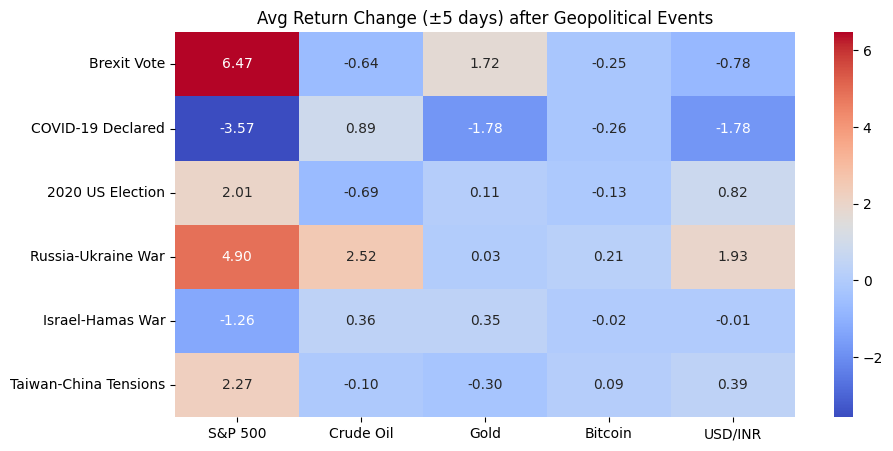

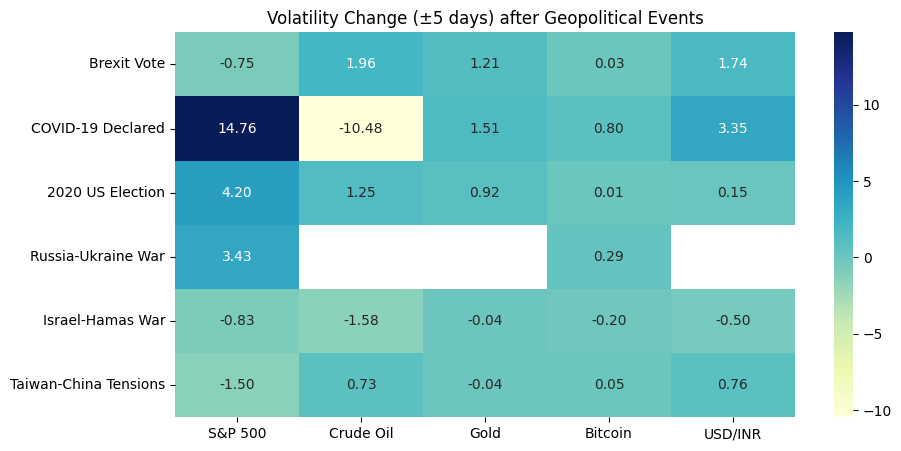

In [ ]:
# Extract just one window view (e.g. ±5 days)
ret_5d = pd.DataFrame({event: data["±5d Return"] for event, data in return_results.items()}).T
vol_5d = pd.DataFrame({event: data["±5d Volatility"] for event, data in volatility_results.items()}).T

plt.figure(figsize=(10,5))
sns.heatmap(ret_5d, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Avg Return Change (±5 days) after Geopolitical Events")
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(vol_5d, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Volatility Change (±5 days) after Geopolitical Events")
plt.show()


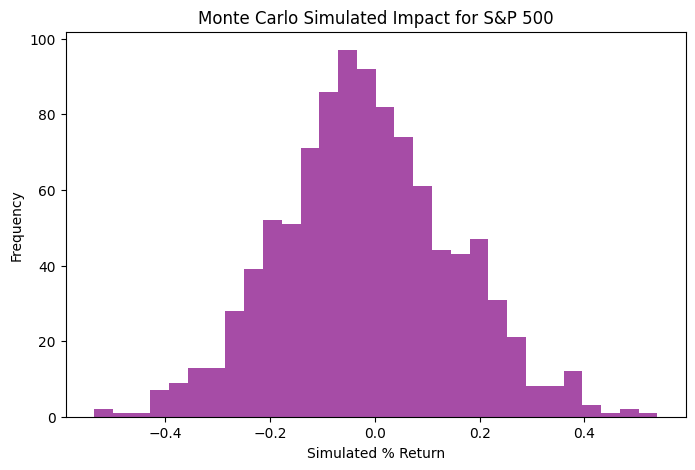

In [ ]:
def monte_carlo_sim(prices, events, trials=1000, window=5):
    """Simulate future event impact based on historical events"""
    all_returns = []
    for event_date in events.values():
        after = prices.loc[event_date: event_date + timedelta(days=window)]
        all_returns.append(after.pct_change().sum())
    mean_ret, std_ret = np.mean(all_returns), np.std(all_returns)
    sims = np.random.normal(mean_ret, std_ret, trials)
    return sims

# Simulate for one example asset
sim_asset = "S&P 500"
sims = monte_carlo_sim(prices[sim_asset], events)

plt.figure(figsize=(8,5))
plt.hist(sims, bins=30, alpha=0.7, color='purple')
plt.title(f"Monte Carlo Simulated Impact for {sim_asset}")
plt.xlabel("Simulated % Return")
plt.ylabel("Frequency")
plt.show()


In [ ]:
print("=== Average Return Impact (±5d) ===")
print(ret_5d)
print("\n=== Volatility Change (±5d) ===")
print(vol_5d)


=== Average Return Impact (±5d) ===
                        S&P 500  Crude Oil      Gold   Bitcoin   USD/INR
Brexit Vote            6.472633  -0.639586  1.715641 -0.253811 -0.777948
COVID-19 Declared     -3.572448   0.891737 -1.779678 -0.262951 -1.777305
2020 US Election       2.005846  -0.693196  0.109709 -0.127681  0.819674
Russia-Ukraine War     4.902070   2.516423  0.025884  0.214880  1.930344
Israel-Hamas War      -1.264347   0.358097  0.352633 -0.020082 -0.013428
Taiwan-China Tensions  2.265088  -0.103942 -0.301784  0.086114  0.385549

=== Volatility Change (±5d) ===
                         S&P 500  Crude Oil      Gold   Bitcoin   USD/INR
Brexit Vote            -0.745608   1.962509  1.212584  0.028979  1.735178
COVID-19 Declared      14.758035 -10.480226  1.510524  0.797674  3.347175
2020 US Election        4.198486   1.253203  0.919185  0.011117  0.147602
Russia-Ukraine War      3.428102        NaN       NaN  0.293394       NaN
Israel-Hamas War       -0.826197  -1.584837 -0.036